<a href="https://colab.research.google.com/github/Valeria-YL/2047880MINERIA/blob/main/Practicas/Practica_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practica 8
Predicción de donaciones de sangre con regresión lineal

In [1]:
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("sumedh1507/blood-donor-dataset")
df = pd.read_csv(os.path.join(path, "blood_donor_dataset.csv"))
df.head(2)

Using Colab cache for faster access to the 'blood-donor-dataset' dataset.


,donor_id,name,email,password,contact_number,city,blood_group,availability,months_since_first_donation,number_of_donation,pints_donated,created_at
0,1b8b4c828a,Norma Fisher,ysullivan@yahoo.com,P5hX6Syg*A,+61 461706749,Hobart,A+,No,65,31,62,2017-03-17
1,a6a3f7fe55,Eugene Bowman,hramos@brown-sellers.com,b6Wq6Cqz@5,+61 450709944,Darwin,AB-,Yes,64,8,16,2016-11-11


Convertimos la columna 'created_at' al formato fecha para realizar el procesamiento de las series temporales con mayor precisión. Después ordenamos los datos cronológicamente.

In [2]:
df['created_at'] = pd.to_datetime(df['created_at'])

df = df.sort_values('created_at')

Agrupamos por mes para construir la serie temporal, lo que permite transformar los registros individuales en una distribución mensual. En este caso, sumamos las pintas donadas, generando una serie temporal que muestra la evolución mensual del volumen de sangre recolectado.

Cada pinta equivale aproximadamente a medio litro, por lo que esta serie refleja la cantidad total de sangre donada mes a mes en litros.

In [3]:
monthly_data = df.groupby(df['created_at'].dt.to_period('M')).agg({'pints_donated': 'sum'}).reset_index()

monthly_data['created_at'] = monthly_data['created_at'].dt.to_timestamp()

Creamos una nueva columna llamda 'time_index' en el dataframe monthly_data. Esta columna nos va a servir como un índice temporal numérico que representa el paso del tiempo de forma secuencial.

In [4]:
monthly_data['time_index'] = range(len(monthly_data))

Entrenamos modelo de regresión lineal para identificar una tendencia en las donaciones de sangre a lo largo del tiempo.

In [5]:
from sklearn.linear_model import LinearRegression

X = monthly_data[['time_index']] #representa el paso de los meses
y = monthly_data['pints_donated'] # cantidad de pintas donadas en cada mes.

model = LinearRegression()
model.fit(X, y)

LinearRegression()

Forecasting

Predice los próximos 6 meses usando el modelo de regresión lineal.


In [6]:
#Crea una columna con números consecutivos que representan los próximos 6 meses, siguiendo el índice temporal que ya teniamos
future_index = pd.DataFrame({'time_index': range(len(monthly_data), len(monthly_data) + 6)})

# Usamos el modelo de regresión lineal que se entreno para estimar cuantas pintas se donarán en los próximos 6 meses
future_predictions = model.predict(future_index)

# Genera las fechas futuras (mes a mes) que corresponden a las predicciones
future_dates = pd.date_range(start=monthly_data['created_at'].max() + pd.offsets.MonthBegin(1), periods=6, freq='MS')

# Creamos un nuevo DataFrame juntando las fechas y las predicciones
forecast_df = pd.DataFrame({'created_at': future_dates, 'predicted_pints_donated': future_predictions})

Visualizamos los resultados.

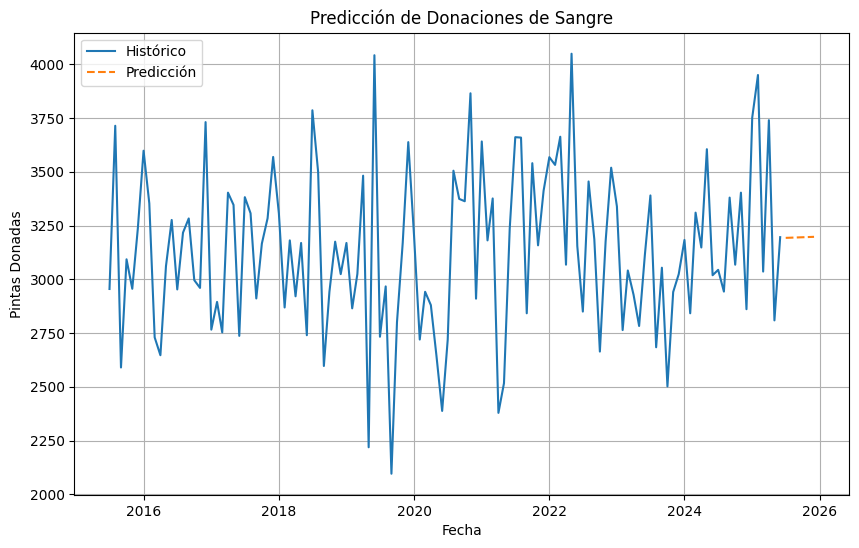

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['created_at'], monthly_data['pints_donated'], label='Histórico')
plt.plot(forecast_df['created_at'], forecast_df['predicted_pints_donated'], label='Predicción', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Pintas Donadas')
plt.title('Predicción de Donaciones de Sangre')
plt.legend()
plt.grid(True)
plt.show()